## কুমড়ার মূল্য নির্ধারণের জন্য লিনিয়ার এবং পলিনোমিয়াল রিগ্রেশন - পাঠ ৩

প্রয়োজনীয় লাইব্রেরি এবং ডেটাসেট লোড করুন। ডেটাকে একটি ডেটাফ্রেমে রূপান্তর করুন যা ডেটার একটি অংশ ধারণ করে:

- শুধুমাত্র সেই কুমড়াগুলো নিন যেগুলো বাসেল অনুযায়ী মূল্য নির্ধারণ করা হয়েছে
- তারিখকে মাসে রূপান্তর করুন
- উচ্চ এবং নিম্ন মূল্যের গড় হিসাব করে মূল্য নির্ধারণ করুন
- মূল্যকে বাসেল পরিমাণ অনুযায়ী রূপান্তর করুন


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

একটি স্ক্যাটারপ্লট আমাদের মনে করিয়ে দেয় যে আমাদের কাছে শুধুমাত্র আগস্ট থেকে ডিসেম্বর পর্যন্ত মাসের ডেটা রয়েছে। সম্ভবত আমাদের আরও ডেটা প্রয়োজন যাতে আমরা একটি সরলরৈখিক পদ্ধতিতে সিদ্ধান্ত নিতে পারি।


<AxesSubplot:xlabel='Month', ylabel='Price'>

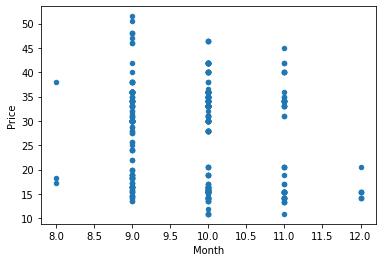

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

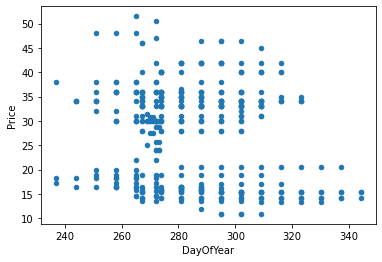

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

চলুন দেখি কোনো সম্পর্ক আছে কিনা:


In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


মনে হচ্ছে সম্পর্কটি বেশ ছোট, তবে আরও গুরুত্বপূর্ণ কিছু সম্পর্ক রয়েছে - কারণ উপরের প্লটে মূল্য পয়েন্টগুলি কয়েকটি স্বতন্ত্র ক্লাস্টারে বিভক্ত। চলুন একটি প্লট তৈরি করি যা বিভিন্ন কুমড়ার প্রজাতি দেখাবে:


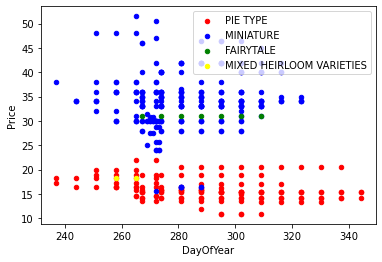

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

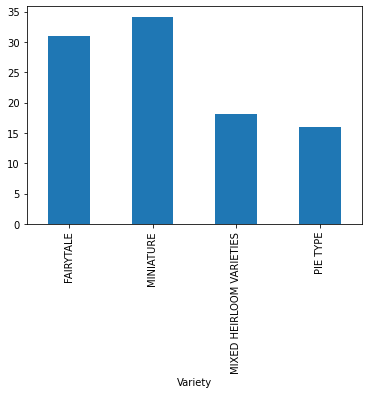

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

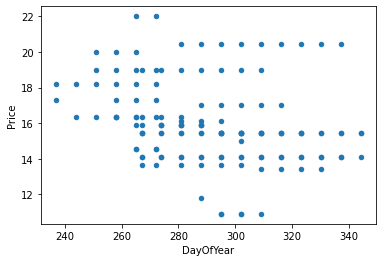

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### লিনিয়ার রিগ্রেশন

আমরা স্কিকিট লার্ন ব্যবহার করে লিনিয়ার রিগ্রেশন মডেল প্রশিক্ষণ করব:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


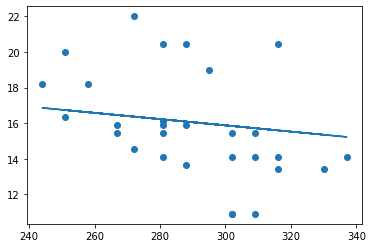

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

রেখার ঢাল লিনিয়ার রিগ্রেশন সহগ থেকে নির্ধারণ করা যেতে পারে:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

আমরা প্রশিক্ষিত মডেলটি ব্যবহার করে মূল্য পূর্বাভাস দিতে পারি:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### পলিনোমিয়াল রিগ্রেশন

কখনও কখনও ফিচার এবং ফলাফলের মধ্যে সম্পর্ক স্বাভাবিকভাবেই অ-রৈখিক হয়। উদাহরণস্বরূপ, কুমড়ার দাম শীতকালে (মাস=১,২) বেশি হতে পারে, তারপর গ্রীষ্মে (মাস=৫-৭) কমে যেতে পারে, এবং পরে আবার বাড়তে পারে। লিনিয়ার রিগ্রেশন এই সম্পর্কটি সঠিকভাবে খুঁজে পেতে অক্ষম।

এই ক্ষেত্রে, আমরা অতিরিক্ত ফিচার যোগ করার কথা বিবেচনা করতে পারি। সহজ উপায় হল ইনপুট ফিচার থেকে পলিনোমিয়াল ব্যবহার করা, যা **পলিনোমিয়াল রিগ্রেশন** তৈরি করবে। সাইকিট লার্ন-এ, আমরা পাইপলাইনের মাধ্যমে স্বয়ংক্রিয়ভাবে পলিনোমিয়াল ফিচার প্রি-কম্পিউট করতে পারি:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


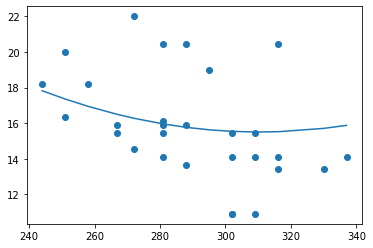

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### এনকোডিং প্রকারভেদ

আদর্শ পরিস্থিতিতে, আমরা চাই একই মডেল ব্যবহার করে বিভিন্ন কুমড়ার প্রকারভেদের দাম পূর্বাভাস দিতে সক্ষম হতে। প্রকারভেদকে বিবেচনায় আনতে, প্রথমে আমাদের এটিকে সংখ্যায় রূপান্তর করতে হবে, বা **এনকোড** করতে হবে। এটি করার কয়েকটি পদ্ধতি রয়েছে:

* সাধারণ সংখ্যাগত এনকোডিং, যা বিভিন্ন প্রকারভেদের একটি টেবিল তৈরি করবে এবং তারপর সেই টেবিলের সূচকের মাধ্যমে প্রকারভেদের নাম প্রতিস্থাপন করবে। এটি লিনিয়ার রিগ্রেশনের জন্য সেরা পদ্ধতি নয়, কারণ লিনিয়ার রিগ্রেশন সূচকের সংখ্যাগত মানকে বিবেচনায় নেয়, এবং সংখ্যাগত মান সম্ভবত দামের সাথে সংখ্যাগতভাবে সম্পর্কিত নয়।
* ওয়ান-হট এনকোডিং, যা `Variety` কলামকে ৪টি ভিন্ন কলামে প্রতিস্থাপন করবে, প্রতিটি প্রকারভেদের জন্য একটি কলাম থাকবে, যেখানে সংশ্লিষ্ট সারি যদি নির্দিষ্ট প্রকারভেদের হয়, তাহলে ১ থাকবে, অন্যথায় ০ থাকবে।

নিচের কোডটি দেখায় কীভাবে আমরা একটি প্রকারভেদকে ওয়ান-হট এনকোড করতে পারি:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### বিভিন্নতার উপর লিনিয়ার রিগ্রেশন

এখন আমরা উপরের একই কোড ব্যবহার করব, তবে `DayOfYear` এর পরিবর্তে ইনপুট হিসেবে আমাদের এক-হট-এনকোড করা বিভিন্নতা ব্যবহার করব:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


আমরা একই পদ্ধতিতে অন্যান্য বৈশিষ্ট্য ব্যবহার করার চেষ্টা করতে পারি এবং সেগুলিকে সংখ্যাগত বৈশিষ্ট্যের সাথে যেমন `Month` বা `DayOfYear` এর সাথে সংযুক্ত করতে পারি:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### পলিনোমিয়াল রিগ্রেশন

পলিনোমিয়াল রিগ্রেশন এক-হট-এনকোড করা ক্যাটেগরিকাল বৈশিষ্ট্যগুলোর সাথেও ব্যবহার করা যেতে পারে। পলিনোমিয়াল রিগ্রেশন প্রশিক্ষণের কোড মূলত উপরে দেখা কোডের মতোই হবে।


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিকতার জন্য চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। মূল ভাষায় থাকা নথিটিকে প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য, পেশাদার মানব অনুবাদ সুপারিশ করা হয়। এই অনুবাদ ব্যবহারের ফলে কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যা হলে আমরা দায়বদ্ধ থাকব না।
